# Model comparison

With our models working reasonably well, we should start to think about comparing the different forms of the model. For example, how do we compare models with tuned normalization to those with untuned normalization? Answering these questions will allow us to determine which model components (i.e. calculations) are key for explaining the neural responses found in our data sets.

In [12]:
import numpy as np
import analyzeEval
import helper_fcns as hf
import autoreload
import sys, os
import pdb

In [34]:
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/Analysis/Functions/paul_plt_style.mplstyle');
import matplotlib.backends.backend_pdf as pltSave
%matplotlib inline

from matplotlib import rcParams, cm
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['font.style'] = 'oblique'
rcParams['font.size'] = 20;
rcParams['pdf.fonttype'] = 3 # should be 42, but there are kerning issues
rcParams['ps.fonttype'] = 3 # should be 42, but there are kerning issues

### Tuned vs Untuned

After presenting my work in an LCV meeting, Tim (Oleskiw) made some suggestions for how to compare two forms of my model. In one form, the normalization is flat over all spatial frequency, while in the other, there is a "tuning" to the normalization pool. In the language of a contrast gain control model, the stimulus energy for particular spatial frequencies is weighted more than stimulus (or contrast) energy in other portions of the frequency spectrum. In the current formulation, the weight of each filter in the normalization pool is weighted according to its position along the weighting function - a two-halved log-Gaussian with an offset. I.e., the weight of each filter is the sum of some overall offest plus the value of the weighting function evaluated at the filter's preferred frequency. 

To compare the models, we hold out one of the N conditions in the experiment (here N is 110, from 5 dispersions with 2 contrasts at 11 spatial frequency centers). Optimize each model for the N-1 conditions and evalulate both the overall loss, and the prediction error on the held out condition. Do this for all N conditions, and compare between the two models

In [3]:
lossType = 3; # 1 - sqrt, 2 - poiss, 3 - modPoiss
expInd = 1; # V1; altExp (V1); LGN
diffs_loss, diffs_pred, losses, preds = analyzeEval.compute_diffs(lossType, expInd=expInd)

if lossType == 1:
     lossStr = 'sqrt'
elif lossType == 2:
     lossStr = 'poiss'
elif lossType == 3:
     lossStr = 'modPoiss'

In [4]:
diffs_loss_all = diffs_loss.flatten();
diffs_pred_all = diffs_pred.flatten();

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:85: RuntimeWarning: Mean of empty slice
/Users/paulgerald/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:88: RuntimeWarning: Mean of empty slice


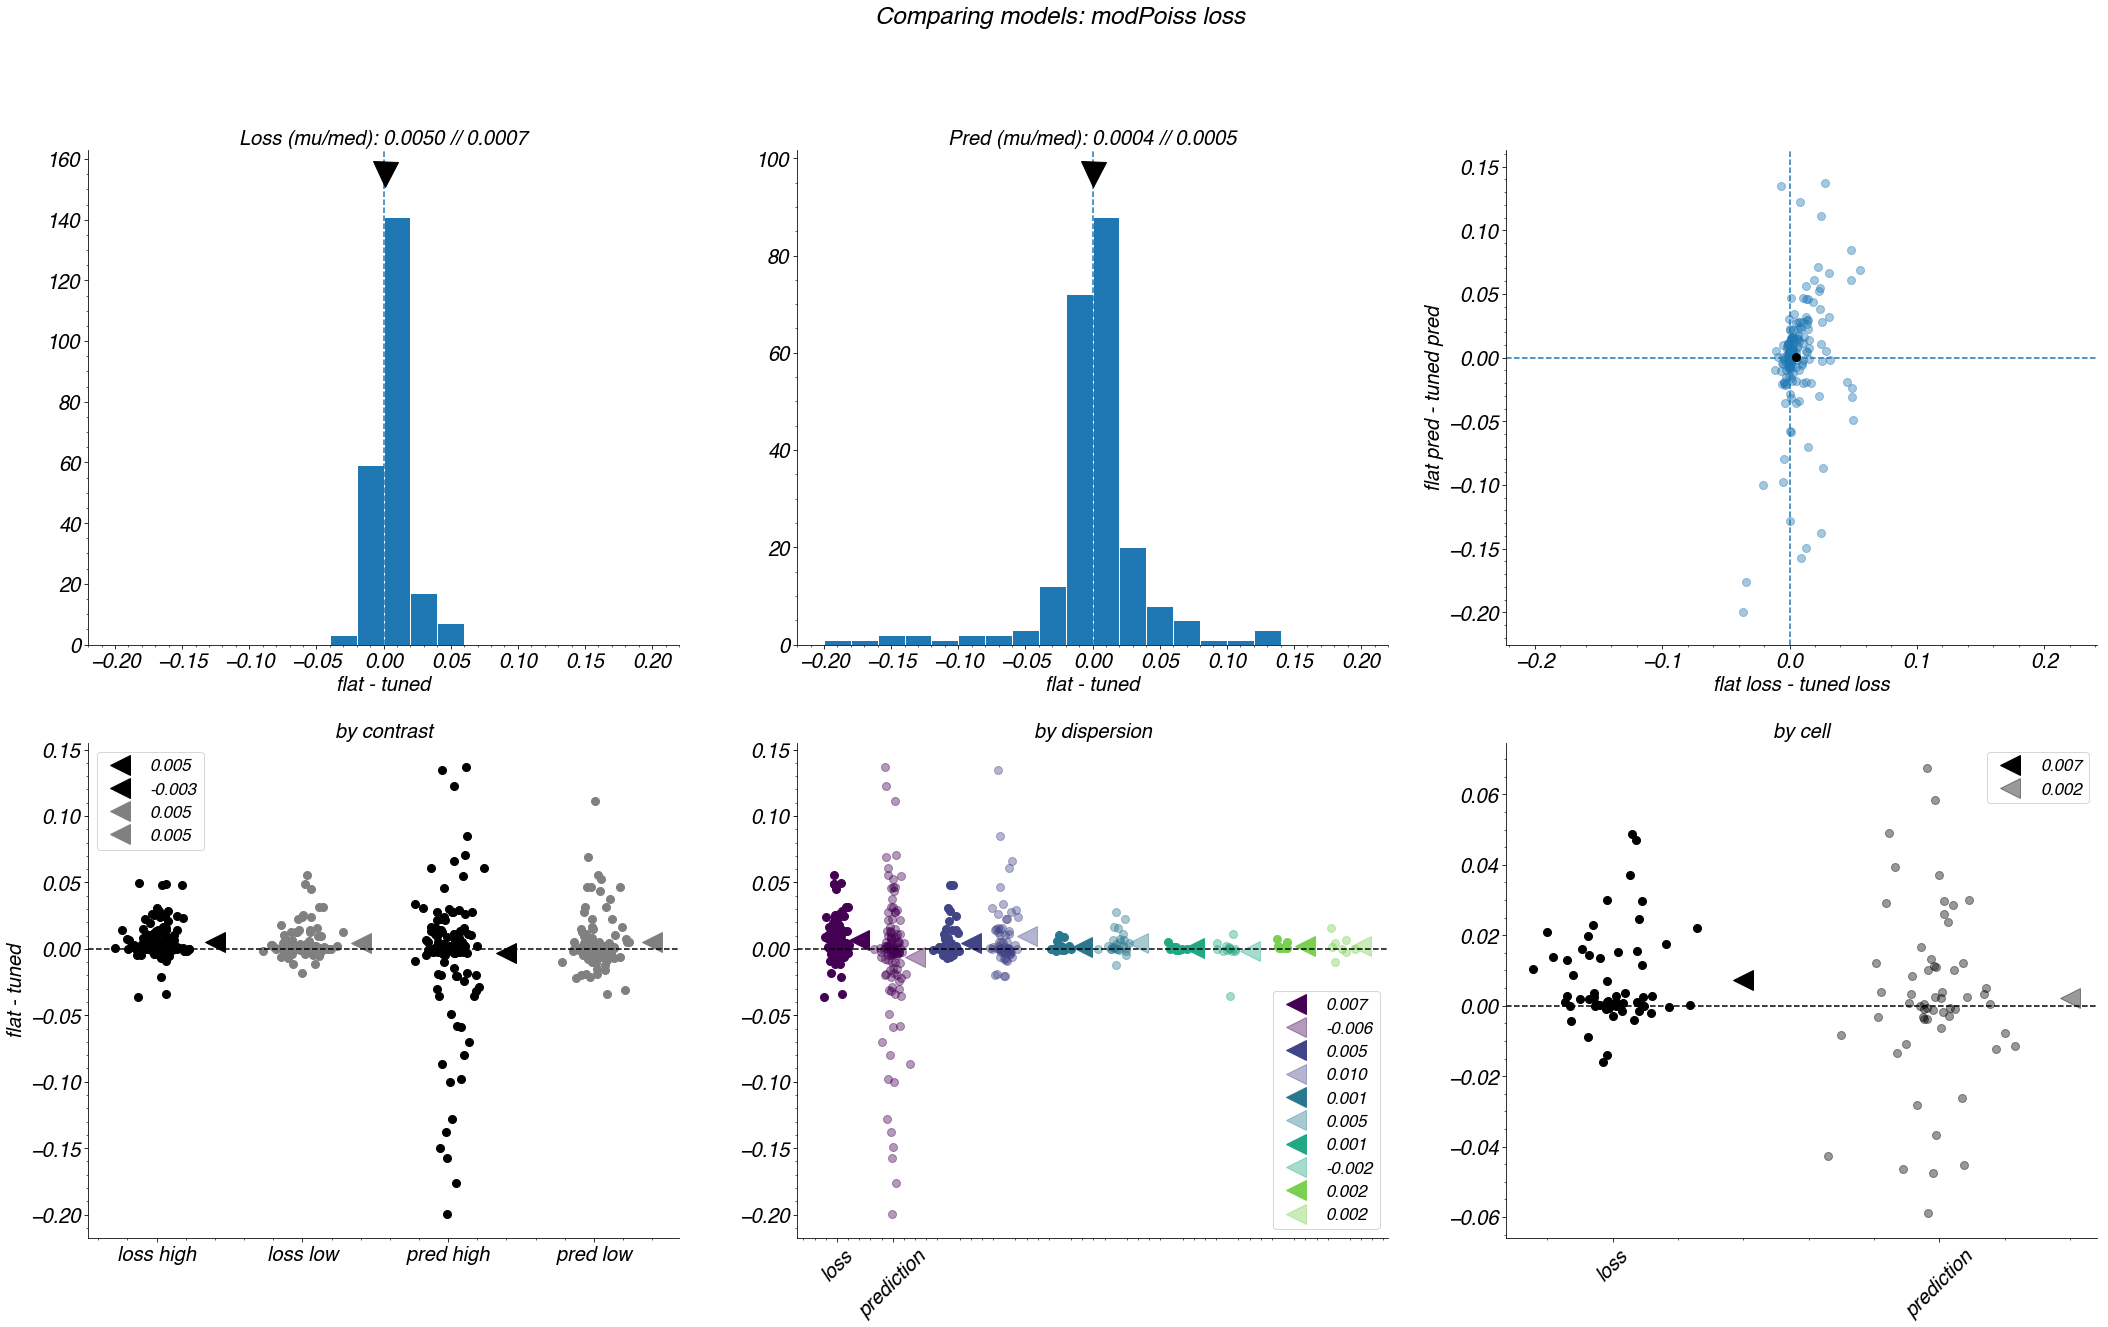

In [62]:
nRows = 2;
nCols = 3;
f, ax = plt.subplots(nRows, nCols, figsize=(12*nCols, 10*nRows))

bins = np.linspace(-0.2, 0.2, 21)

## ALL CONDITIONS

# just loss
plt.subplot(nRows, nCols, 1)
non_nan = diffs_loss_all[~np.isnan(diffs_loss_all)];
n, _, _ = plt.hist(non_nan, bins=bins)
plt.axvline(0, ls='--')
plt.plot(np.median(non_nan), 1.1*np.max(n), 'v', markersize=25, color='k')
plt.xlabel('flat - tuned')
plt.title('Loss (mu/med): %.4f // %.4f' % (np.mean(non_nan), np.median(non_nan)))

# just prediction error
plt.subplot(nRows, nCols, 2)
non_nan = diffs_pred_all[~np.isnan(diffs_pred_all)];
n, _, _ = plt.hist(diffs_pred_all[~np.isnan(diffs_pred_all)], bins=bins)
plt.axvline(0, ls='--')
plt.plot(np.median(non_nan), 1.1*np.max(n), 'v', markersize=25, color='k')
plt.xlabel('flat - tuned')
plt.title('Pred (mu/med): %.4f // %.4f' % (np.mean(non_nan), np.median(non_nan)))

# expanded
plt.subplot(nRows, nCols, 3)
plt.scatter(diffs_loss_all, diffs_pred_all, alpha=0.4);
plt.axhline(0, ls='--')
plt.axvline(0, ls='--')
plt.plot(np.nanmean(diffs_loss_all), np.nanmean(diffs_pred_all), 'o', color='k')
plt.xlabel('flat loss - tuned loss');
plt.ylabel('flat pred - tuned pred');
plt.axis('equal');

## SLICES (e.g. by cell)
# by contrast
plt.subplot(nRows, nCols, 4)
high_con = [0, 0, 0]; low_con = [0.5, 0.5, 0.5];
colors = [high_con, low_con];
mark_size = 20;

for i in range(2): # 2 contrasts

    loss_curr = diffs_loss[:, :, i].flatten()
    plt.plot(i + 0.4, np.nanmean(loss_curr), '<', markersize=mark_size, color=colors[i], label='%.3f' % np.nanmean(loss_curr))
    plt.scatter(np.random.normal(loc=i, scale=0.1, size=loss_curr.shape), loss_curr, color=colors[i])
    
    pred_curr = diffs_pred[:, :, i].flatten()
    plt.plot(i + 2.4, np.nanmean(pred_curr), '<', markersize=mark_size, color=colors[i], label='%.3f' % np.nanmean(pred_curr))
    plt.scatter(np.random.normal(loc=2 + i, scale=0.1, size=pred_curr.shape), pred_curr, color=colors[i])

plt.legend(fontsize='small');
plt.title('by contrast')
plt.axhline(0, ls='--', color='k')
plt.xticks(np.arange(4), ('loss high', 'loss low', 'pred high', 'pred low'))
plt.ylabel('flat - tuned');
# plt.axis('equal');

# by dispersion
plt.subplot(nRows, nCols, 5)
nDisps = 5;
colors = cm.viridis(np.linspace(0, 0.8, nDisps))
mark_size = 20;

for i in range(nDisps):

    loss_curr = diffs_loss[:, i, :].flatten()
    plt.plot(2*i + 0.4, np.nanmean(loss_curr), '<', markersize=mark_size, color=colors[i], label='%.3f' % np.nanmean(loss_curr))
    plt.scatter(np.random.normal(loc=2*i, scale=0.1, size=loss_curr.shape), loss_curr, color=colors[i])
    pred_curr = diffs_pred[:, i, :].flatten()
    plt.plot(2*i + 1.4, np.nanmean(pred_curr), '<', markersize=mark_size, color=colors[i], alpha=0.4, label='%.3f' % np.nanmean(pred_curr))
    plt.scatter(np.random.normal(loc=2*i+1, scale=0.1, size=pred_curr.shape), pred_curr, color=colors[i], alpha=0.4)

plt.legend(fontsize='small');
plt.title('by dispersion')
plt.axhline(0, ls='--', color='k')
plt.xticks(np.arange(2), ('loss', 'prediction'), rotation=45)

# by cell
plt.subplot(nRows, nCols, 6)
mark_size = 20;

loss_curr = np.nanmean(np.nanmean(diffs_loss, 1), 1);
plt.plot(0.4, np.nanmean(loss_curr), '<', markersize=mark_size, color=high_con, label='%.3f' % np.nanmean(loss_curr))
plt.scatter(np.random.normal(loc=0, scale=0.1, size=loss_curr.shape), loss_curr, color=high_con)
pred_curr = np.nanmean(np.nanmean(diffs_pred, 1), 1);
plt.plot(1.4, np.nanmean(pred_curr), '<', markersize=mark_size, color=high_con, alpha=0.4, label='%.3f' % np.nanmean(pred_curr))
plt.scatter(np.random.normal(loc=1, scale=0.1, size=pred_curr.shape), pred_curr, color=high_con, alpha=0.4)

plt.legend(fontsize='small');
plt.title('by cell')
plt.axhline(0, ls='--', color='k')
plt.xticks(np.arange(2), ('loss', 'prediction'), rotation=45)


plt.suptitle('Comparing models: %s loss' % lossStr);

# now save
pdf = pltSave.PdfPages(str('figures/' + 'modCompare.pdf'))
pdf.savefig(f, bbox_inches="tight")
pdf.close()

### LGN vs. V1

Load the model fits from both LGN and V1 datasets to compare across brain areas.

In [63]:
fitType  = 1; # 1 - flat; 2 - gaussian weights; 3 - adjustable c50
lossType = 3;

LGNbase = 'fitList_181115'
V1base  = 'fitList_181015'

fits_LGN = hf.np_smart_load(str('../LGN/analysis/structures/' + hf.fitList_name(LGNbase, fitType, lossType)))
fits_V1  = hf.np_smart_load(str('../Analysis/Structures/' + hf.fitList_name(V1base, fitType, lossType)))

In [67]:
c50_ind = 2;
prefSf_ind = 0;
if fitType == 2:
    normSf_ind = 8;
    normSig_ind = 9;

In [68]:
lgn = dict();
v1  = dict();

lgn['NLL'] = [fits_LGN[x]['NLL'] for x in fits_LGN]
v1['NLL']  = [fits_V1[x]['NLL'] for x in fits_V1]

lgn['params'] = [fits_LGN[x]['params'] for x in fits_LGN]
v1['params']  = [fits_V1[x]['params'] for x in fits_V1]

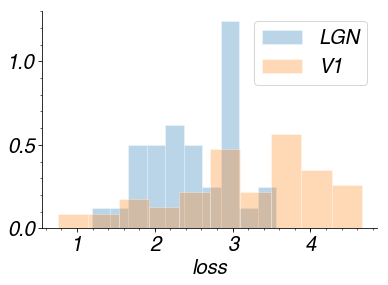

In [69]:
plt.hist(lgn['NLL'], alpha=0.3, label='LGN', normed=True);
plt.hist(v1['NLL'], alpha=0.3, label='V1', normed=True);
plt.xlabel('loss');
plt.legend();

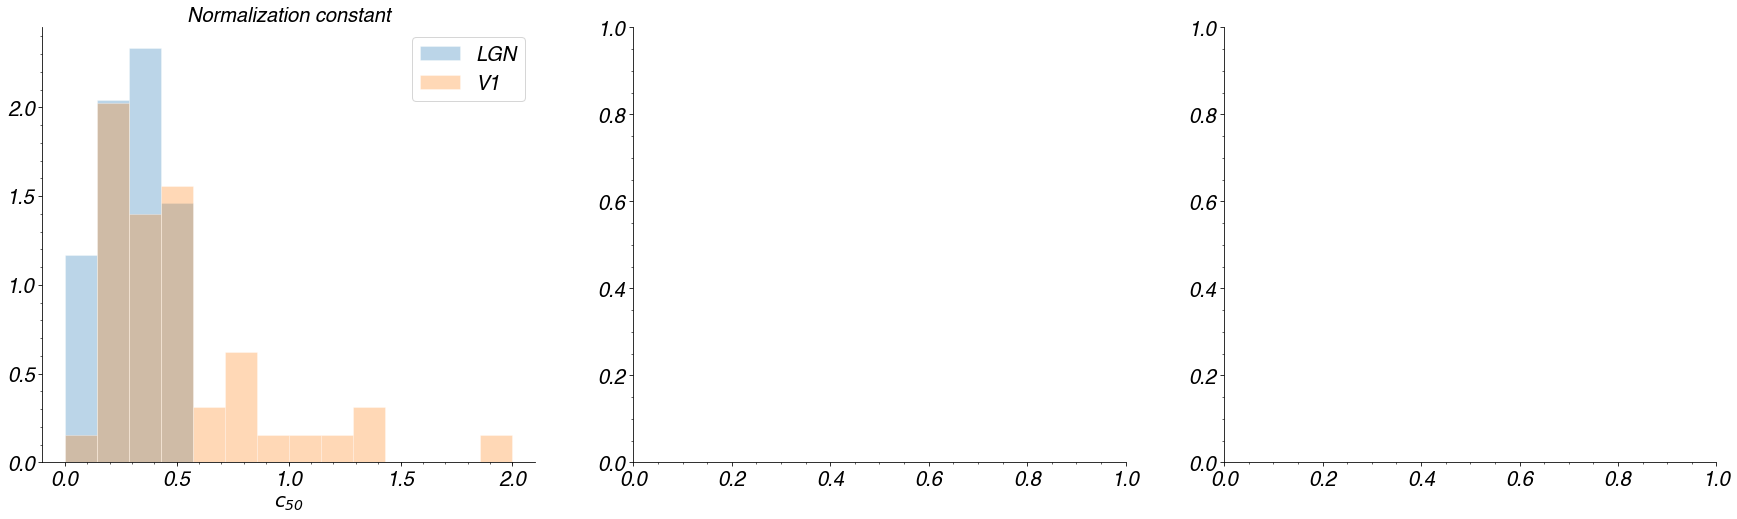

In [70]:
# normalization?
nRow = 1; nCol = 3;
f, ax = plt.subplots(nRow, nCol, figsize=(10*nCol, 8*nRow))

plt.subplot(nRow, nCol, 1);
bins = np.linspace(0, 2, 15)
plt.hist(np.power(10, [x[c50_ind] for x in lgn['params']]), bins=bins, alpha=0.3, label='LGN', normed=True);
plt.hist(np.power(10, [x[c50_ind] for x in v1['params']]), bins=bins, alpha=0.3, label='V1', normed=True);
plt.xlabel(r'$c_{50}$');
plt.title('Normalization constant')
plt.legend();

# what is the peak of the normalization pool relative to the filter?
if fitType == 2:
    plt.subplot(nRow, nCol, 2);
    bins = np.linspace(-4, 4, 15)
    lgn_shifts = np.array([np.log2(np.divide(x[normSf_ind], x[prefSf_ind])) for x in lgn['params']])
    plt.hist(lgn_shifts[~np.isnan(lgn_shifts)], bins=bins, alpha=0.3, label='LGN', normed=True);
    v1_shifts = np.array([np.log2(np.divide(x[normSf_ind], x[prefSf_ind])) for x in v1['params']])
    plt.hist(v1_shifts[~np.isnan(v1_shifts)], bins=bins, alpha=0.3, label='V1', normed=True);
    plt.xlabel(r'$mu$ ratio (log)');
    plt.title('Norm peak shift')
    plt.legend();

    plt.subplot(nRow, nCol, 3);
    bins = np.linspace(0, 2, 15)
    plt.hist([x[normSig_ind] for x in lgn['params']], bins=bins, alpha=0.3, label='LGN', normed=True);
    plt.hist([x[normSig_ind] for x in v1['params']], bins=bins, alpha=0.3, label='V1', normed=True);
    plt.xlabel(r'$\sigma$');
    plt.title('Norm std')
    plt.legend();